---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Pratham Kabra
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-13-04"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/lab08-PrathamKabra/data/lightcast_job_postings.csv")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

#df.printSchema() # comment this line when rendering the submission
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 01:04:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [13]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PolynomialExpansion
from pyspark.ml import Pipeline
from setuptools import setup

# Drop rows with NA values in relevant columns 
df = df.dropna(subset=[
    "SALARY", 'MIN_YEARS_EXPERIENCE', 'DURATION', 'EMPLOYMENT_TYPE_NAME', 'IS_INTERNSHIP'])

# Categorical columns
categorical_cols = ['EMPLOYMENT_TYPE_NAME', 'IS_INTERNSHIP'] 

# Continuous columns
continuous_cols = ['MIN_YEARS_EXPERIENCE', 'DURATION']

df = df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast("integer"))

# Index and One-Hot Encode categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=f"{col}_vec", dropLast=True) for col in categorical_cols]

# Assemble base features (for GLR and Random Forest)
assembler = VectorAssembler(
    inputCols=continuous_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

poly = PolynomialExpansion(
    inputCol="features",
    outputCol="features_poly",
    degree=2
)

# Build pipeline and transform
pipeline = Pipeline(stages=indexers + encoders + [assembler, poly])
pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df)

# Show final structure
data.select("SALARY", "features").show(5)

+------+--------------------+
|SALARY|            features|
+------+--------------------+
|192800|[6.0,55.0,1.0,0.0...|
|125900|[12.0,18.0,1.0,0....|
|118560|[5.0,20.0,1.0,0.0...|
|192800|[6.0,55.0,1.0,0.0...|
|116500|[12.0,16.0,1.0,0....|
+------+--------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [14]:
#| eval: true
#| echo: false
#| fig-align: center

train_data, test_data = data.randomSplit([0.7, 0.3], seed=957)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(2371, 137)


(1033, 137)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [15]:
#| eval: true
#| echo: true
#| fig-align: center

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from tabulate import tabulate
import numpy as np
import pandas as pd

# Step 1: Train the LinearRegression model
lr = LinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    regParam=0.1
)
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Step 2: Evaluate the model on test data
predictions = lr_model.transform(test_data)

# Compute R², RMSE, and MAE using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

# Step 3: Extract coefficients, intercept, and stats from the summary
intercept = lr_model.intercept
feature_coefs = lr_model.coefficients.toArray()

all_se = np.array(summary.coefficientStandardErrors)  # includes intercept
all_t = np.array(summary.tValues)
all_p = np.array(summary.pValues)

# Step 4: Compute confidence intervals (95% CI: ±1.96 * standard error)
coefs_with_intercept = np.array([intercept] + feature_coefs.tolist())
ci_lower = coefs_with_intercept - 1.96 * all_se
ci_upper = coefs_with_intercept + 1.96 * all_se

# Step 5: Recover feature names from VectorAssembler metadata and generate polynomial names
meta = train_data.schema["features"].metadata
attrs = []
for _, alist in meta["ml_attr"]["attrs"].items():
    attrs.extend(alist)
original_feat_names = [a["name"] for a in attrs]

# Generate polynomial feature names for degree 2
feat_names = []
degree = 2  # From PolynomialExpansion

# Original features (degree 1)
for fname in original_feat_names:
    feat_names.append(fname)

# Square terms (degree 2: x^2)
for fname in original_feat_names:
    feat_names.append(f"{fname}^2")

# Interaction terms (degree 2: x*y for all pairs)
for i, fname1 in enumerate(original_feat_names):
    for fname2 in original_feat_names[i + 1:]:
        feat_names.append(f"{fname1}*{fname2}")

assert len(feat_names) == len(feature_coefs), "Feature name/coef length mismatch!"

# Step 6: Pack into lists (intercept first)
features = ["intercept"] + feat_names
coefs = [intercept] + feature_coefs.tolist()
std_errs = all_se.tolist()
t_vals = all_t.tolist()
p_vals = all_p.tolist()
ci_lower_vals = ci_lower.tolist()
ci_upper_vals = ci_upper.tolist()

# Step 7: Print model performance metrics
print("Model Performance Metrics:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}\n")

# Step 8: Create a DataFrame to display coefficients and stats
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": std_errs,
    "t-stat": t_vals,
    "P-Value": p_vals,
    "CI Lower (95%)": ci_lower_vals,
    "CI Upper (95%)": ci_upper_vals
})

# Step 9: Pretty print the table
print("Coefficient Table:")
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

Model Performance Metrics:
R²: 0.2660
RMSE: 35540.5139
MAE: 26979.8056

Coefficient Table:
+----+-------------------------------------------------------------------------------------------------+---------------------+--------------------+-----------------------+-----------------------+---------------------+---------------------+
|    |                                             Feature                                             |      Estimate       |     Std Error      |        t-stat         |        P-Value        |   CI Lower (95%)    |   CI Upper (95%)    |
+----+-------------------------------------------------------------------------------------------------+---------------------+--------------------+-----------------------+-----------------------+---------------------+---------------------+
| 0  |                                            intercept                                            | 251593.03157228383  | 16945.686529215316 |  1.3668743065999196   |  0.17179545014675

## Generalized Linear Regression Summary

The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [16]:
#| eval: true
#| echo: true
#| fig-align: center

from pyspark.ml.regression import GeneralizedLinearRegression
from tabulate import tabulate
import numpy as np
import pandas as pd

# Step 1: Train the GeneralizedLinearRegression model
glr = GeneralizedLinearRegression(
    featuresCol="features",  
    labelCol="SALARY",       
    family="gaussian",       
    link="identity",         
    regParam=0.1             
)

# Fit the model on the training data
glr_model = glr.fit(train_data)

# Step 2: Get the summary of the fitted model
summary = glr_model.summary

# Step 3: Extract key statistics from the summary
# Intercept and coefficients
intercept = glr_model.intercept
feature_coefs = glr_model.coefficients.toArray()  

# Standard errors, t-values, and p-values (including intercept)
all_se = np.array(summary.coefficientStandardErrors)
all_t = np.array(summary.tValues)
all_p = np.array(summary.pValues)

# Step 4: Extract feature names from the VectorAssembler metadata
meta = train_data.schema["features"].metadata
attrs = []
for _, alist in meta["ml_attr"]["attrs"].items():
    attrs.extend(alist)
feat_names = [a["name"] for a in attrs]

# Verify that the number of feature names matches the number of coefficients
assert len(feat_names) == len(feature_coefs), "Feature name/coef length mismatch!"

# Step 5: Pack the stats into lists (intercept first)
features = ["intercept"] + feat_names
coefs = [intercept] + feature_coefs.tolist()
std_errs = all_se.tolist()
t_vals = all_t.tolist()
p_vals = all_p.tolist()

# Step 6: Create a DataFrame to display the summary
summary_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": std_errs,
    "t-stat": t_vals,
    "P-Value": p_vals
})

print(f"Length of features: {len(features)}")
print(f"Length of coefs:    {len(coefs)}")
print(f"Length of se:       {len(std_errs)}")
print(f"Length of tvals:    {len(t_vals)}")
print(f"Length of pvals:    {len(p_vals)}\n")

# Step 7: Print the summary table
print("Generalized Linear Regression Summary:")
print(tabulate(summary_table, headers="keys", tablefmt="pretty"))


Length of features: 6
Length of coefs:    6
Length of se:       6
Length of tvals:    6
Length of pvals:    6

Generalized Linear Regression Summary:
+---+-------------------------------------------------+---------------------+--------------------+---------------------+------------------------+
|   |                     Feature                     |      Estimate       |     Std Error      |       t-stat        |        P-Value         |
+---+-------------------------------------------------+---------------------+--------------------+---------------------+------------------------+
| 0 |                    intercept                    |  80330.1770777458   | 225.36288804234118 | 30.016889182342844  |          0.0           |
| 1 |              MIN_YEARS_EXPERIENCE               |  6764.692836179693  | 51.61919722893955  | -0.4711341579731859 |   0.6375883873721999   |
| 2 |                    DURATION                     | -24.319567021708245 | 6598.632583017811  | -0.989411399143492  |

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


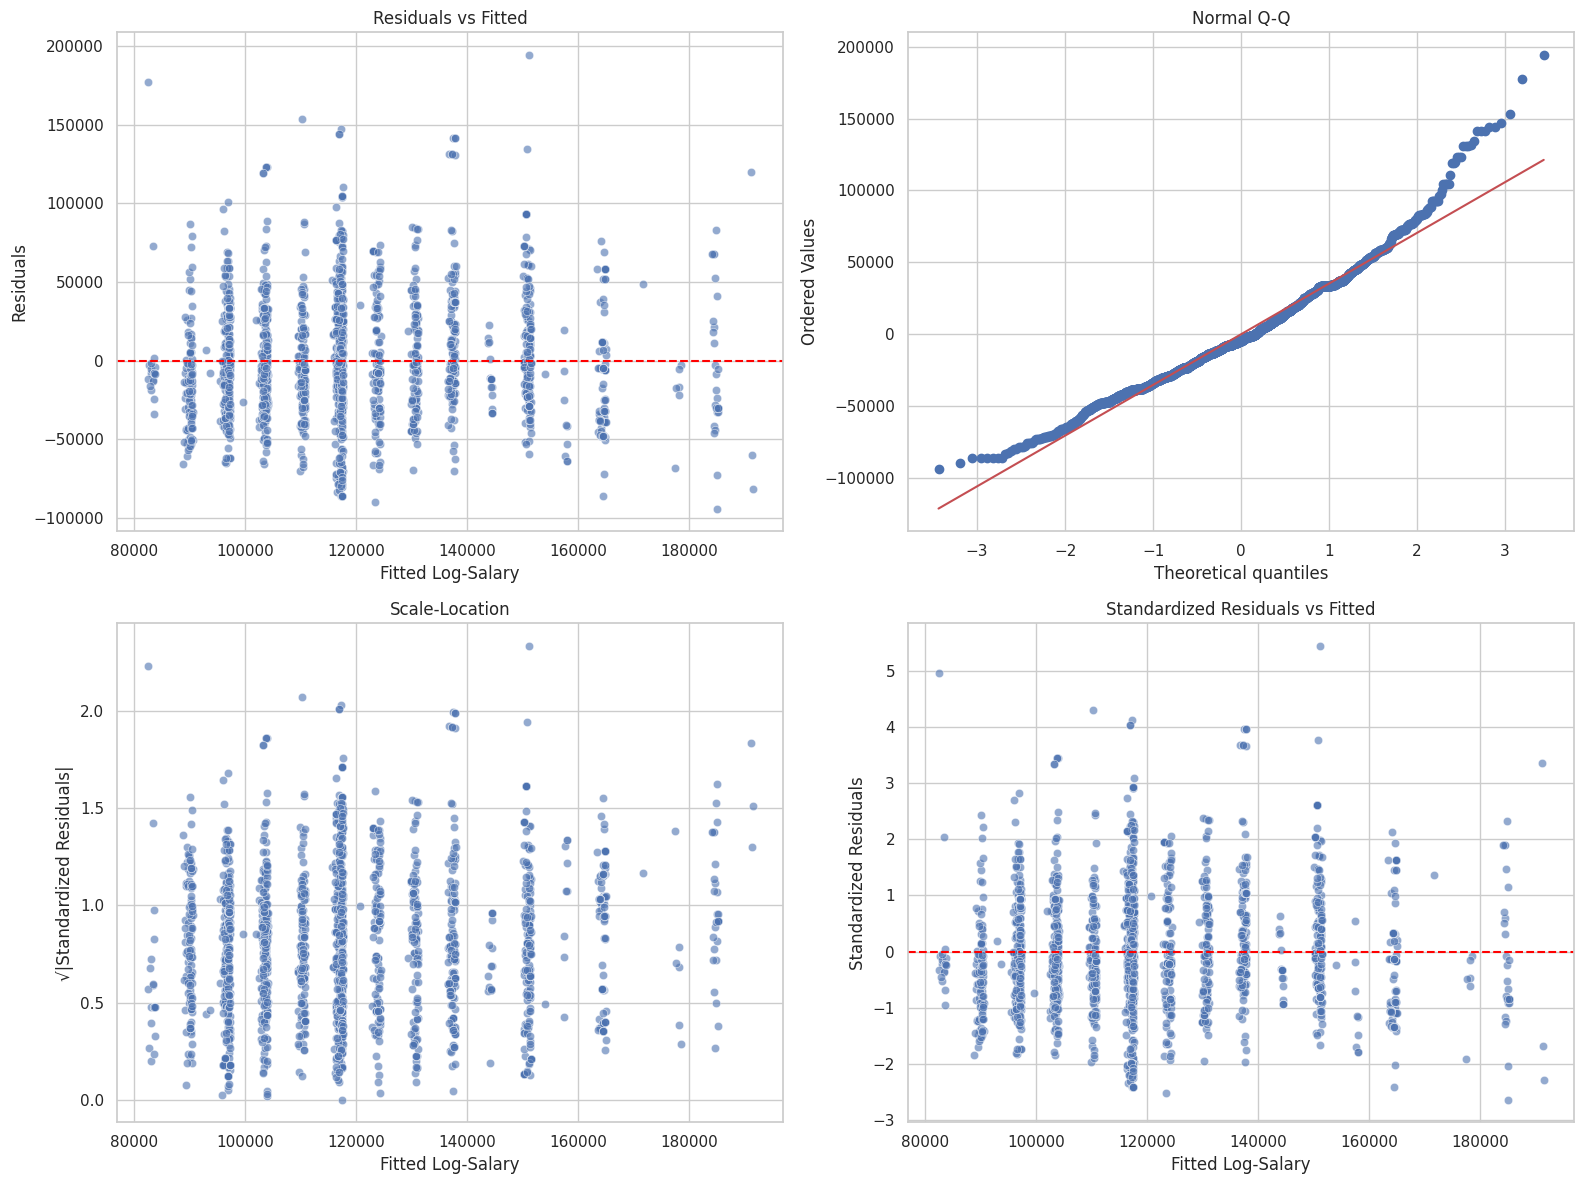

In [23]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Convert predictions to pandas
df_pred = summary.predictions.select("prediction", "SALARY").toPandas()

# Residuals and fitted values
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Plot layout
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# 1. Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Residuals")

# 2. Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# 3. Scale-Location Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred, alpha=0.6)
plt.title("Scale-Location")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("√|Standardized Residuals|")

# 4. Standardized Residuals vs Fitted
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Standardized Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Standardized Residuals")

# Output
plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Predict on test set
pred_glr = lr_model.transform(test_data)

# 1. R² Evaluation
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# 2. BIC Calculation
n = pred_glr.count()
k = len(lr_model.coefficients)
rss = pred_glr.select(pow(col("SALARY") - col("prediction"), 2).alias("squared_error")) \
              .agg({"squared_error": "sum"}).collect()[0][0]
bic = n * np.log(rss / n) + k * np.log(n)

# 3. RMSE (manual)
rmse = np.sqrt(rss / n)

# 4. Print Evaluation Summary
print("\n--- Model Evaluation on SALARY ---")
print(f"R²     : {r2:.4f}")
print(f"RMSE   : {rmse:.4f}")




--- Model Evaluation on SALARY ---
R²     : 0.0728
RMSE   : 31862.9074


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

/home/ubuntu/lab08-PrathamKabra/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in expm1

/home/ubuntu/lab08-PrathamKabra/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

overflow encountered in expm1



Index(['prediction', 'SALARY', 'actual_salary', 'predicted_salary'], dtype='object')


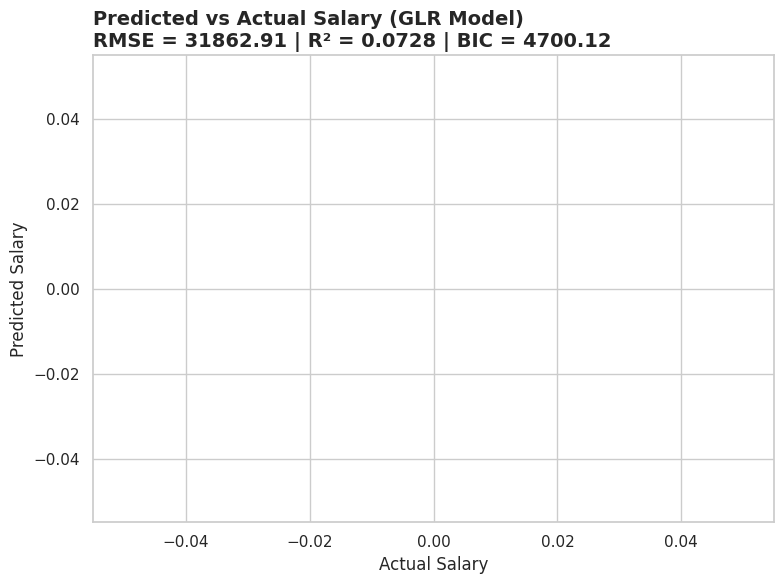

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert predictions to pandas
pandas_df = pred_glr.select("prediction", "SALARY").toPandas()

pandas_df["actual_salary"] = np.expm1(pandas_df["SALARY"])
pandas_df["predicted_salary"] = np.expm1(pandas_df["prediction"])


print(pandas_df.columns)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="actual_salary", y="predicted_salary", data=pandas_df, alpha=0.6)

# Reference line
plt.plot([pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         [pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         color="red", linestyle="--")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | BIC = {bic:.2f}", 
          loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
